In [1]:
import gymnasium as gym
import numpy as np
import imageio
import cv2
from IPython.display import Image
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class QNetwork(nn.Module):
    def __init__(self,input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64,output_size)
        self.softmax = nn.Softmax(dim=-1)

        for param in self.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [4]:
class Agent:
    def __init__(self, env, gamma, input_size, output_size, batch_size):
        self.env = env
        self.gamma = gamma
        self.policy_network = QNetwork(input_size, output_size)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=0.01)
        self.batch_size = batch_size

    def generate_trajectory(self):
        states = []
        actions = []
        rewards = []
        state,_ = self.env.reset()
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action_probs = self.policy_network(torch.tensor(state,dtype=torch.float))
            action = torch.multinomial(action_probs,1).item()
            next_state,reward,terminated,truncated,_ = self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state 
        return states, actions,rewards

    def create_reward_to_go(self,rewards):
        compute = np.zeros_like(rewards,dtype=np.float32)
        compute[-1] = rewards[-1] #equating last element
        for t in range(len(rewards)-2,-1, -1):
            compute[t] = rewards[t] + self.gamma*compute[t + 1]
        return torch.tensor(compute,dtype=torch.float)
    
    def calculate_discounted_sum(self,rewards):
        discounted_sum = rewards[0]
        for i in range(len(rewards)-1,0,-1):
            discounted_sum = rewards[i] + self.gamma*discounted_sum
        return discounted_sum

    def policy_gradient_update(self, enable_reward_to_go=False, enable_advantage_normalization=False):
        
        loss = torch.tensor([0.0])
        avg_reward = np.array([0.0])
        
        s_batch,a_batch,r_batch = [],[],[]
        ls = []
        for _ in range(self.batch_size):
            s,a,r = self.generate_trajectory() 
            s,a,r = np.array(s,dtype=np.float32),np.array(a,dtype = int),np.array(r,dtype=np.float32)
            ls.append(self.calculate_discounted_sum(r))
            s_batch.append(s)
            a_batch.append(a)
            r_batch.append(r)
        mean = torch.tensor(np.mean(ls))
        std = torch.tensor(np.std(ls))
        
        for s,a,r in zip(s_batch,a_batch,r_batch):
            avg_reward += r.sum()
            
            states = torch.tensor(s,dtype=torch.float)
            actions = torch.tensor(a,dtype=torch.long)
            rewards = torch.tensor(r,dtype=torch.float)
            #---------------------------------------------
            action_probs = self.policy_network(states)
            selected_log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)))
            
            if enable_reward_to_go:
                rewards = self.create_reward_to_go(rewards)
            else:
                rewards = self.calculate_discounted_sum(rewards).repeat(len(rewards))
                
            baseline = torch.tensor([0.0]).repeat(len(rewards))
            if enable_advantage_normalization:
                baseline = (rewards - mean)/(std + 1e-7)#offset
                
            loss -= torch.sum(selected_log_probs.view(-1)*(rewards - baseline))
            
        self.optimizer.zero_grad()
        loss = loss/self.batch_size
        loss.backward()
        self.optimizer.step()
        avg_reward /= self.batch_size
        return loss.item(),avg_reward

In [5]:
def train_agent(agent,list_loss,list_reward,num_iterations, enable_reward_to_go=False, enable_advantage_normalization=False):
    for iteration in range(num_iterations):
        loss,reward = agent.policy_gradient_update(enable_reward_to_go, enable_advantage_normalization)
        list_loss.append(loss)
        list_reward.append(reward)
        if iteration % 20 == 0:
            print(f'loss : {loss} , reward: {reward}')

In [6]:
def run_testing_and_create_gif(agent,gif_path='testing.gif',frame_duration=0.05):
    state, _ = agent.env.reset()
    terminated = False
    truncated = False
    frames = []
    total_reward = 0
    count = 0
    while not (terminated or truncated):
        action_probs = agent.policy_network(torch.tensor(state, dtype=torch.float))
        action = torch.multinomial(action_probs, 1).item()
        next_state,reward,terminated,truncated,_ = agent.env.step(action)
        state = next_state
        total_reward += reward
        frames.append(agent.env.render())
        count += 1

    print("total_reward: ",total_reward,"count :",count)
    print(len(frames))
    imageio.mimsave(gif_path,frames,duration=frame_duration)

<p>here we have created all necessary functions and we use rewards_to_go , advanced_normalization we set it true or false based on our needs</p>

In [7]:
env1 = gym.make('CartPole-v0',render_mode = 'rgb_array')
input_size = env1.observation_space.shape[0]
output_size = env1.action_space.n
batch_size = 64
agent = Agent(env1,0.99,input_size, output_size,batch_size)
loss_env1_F_F = []
reward_env1_F_F = []

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


loss : 457.7625427246094 , reward: [24.265625]
loss : 685.9464721679688 , reward: [30.421875]
loss : 894.15869140625 , reward: [35.5]
loss : 995.9866333007812 , reward: [39.90625]
loss : 1451.4700927734375 , reward: [49.25]
loss : 1606.4405517578125 , reward: [54.78125]
loss : 2066.451904296875 , reward: [64.96875]
loss : 2660.7265625 , reward: [76.015625]
loss : 4643.77197265625 , reward: [110.25]
loss : 5743.3779296875 , reward: [130.40625]
loss : 7656.73779296875 , reward: [161.59375]
loss : 8559.3935546875 , reward: [177.6875]
loss : 7340.7705078125 , reward: [158.6875]
loss : 8274.9453125 , reward: [173.46875]
loss : 8942.111328125 , reward: [185.046875]


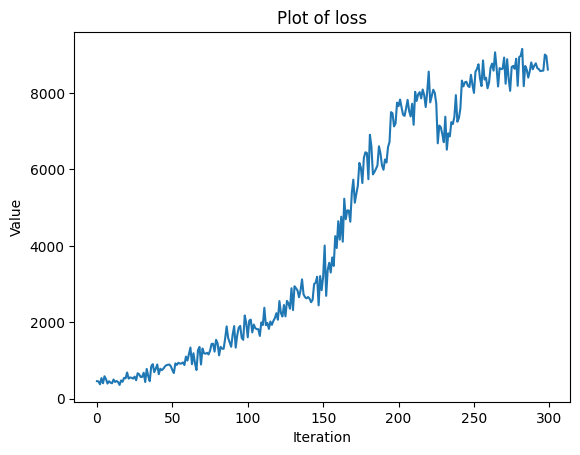

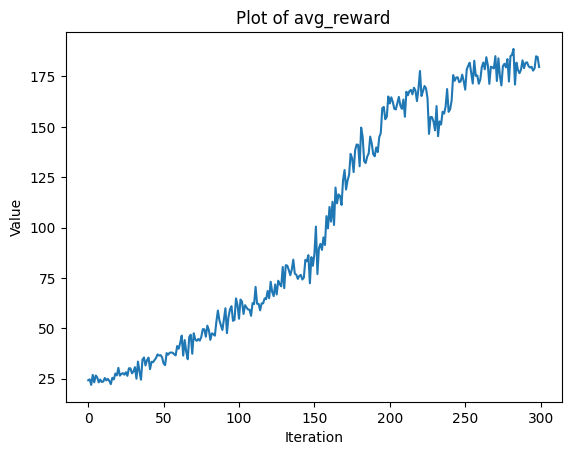

In [8]:
train_agent(agent,loss_env1_F_F,reward_env1_F_F, num_iterations=300,enable_reward_to_go=False,enable_advantage_normalization=False)
plt.plot(loss_env1_F_F)
plt.title('Plot of loss')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

plt.plot(reward_env1_F_F)
plt.title('Plot of avg_reward')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

total_reward:  136.0 count : 136
136


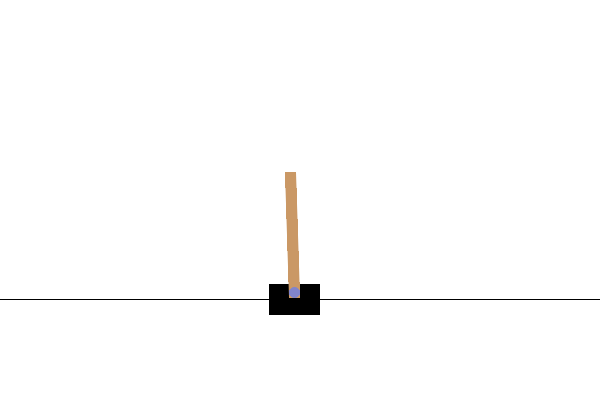

In [9]:
run_testing_and_create_gif(agent,gif_path='testing1.gif')
display(Image(filename='testing1.gif'))

<p>As we can see after some iteartion we can see the pole is balanced </p>

In [10]:
del agent
batch_size = 64
agent = Agent(env1,0.99,input_size, output_size,batch_size)
loss_env1_T_F = []
reward_env1_T_F = []

train_agent(agent,loss_env1_T_F,reward_env1_T_F, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=False)

loss : 285.81524658203125 , reward: [27.34375]
loss : 339.9740905761719 , reward: [30.34375]
loss : 631.2523193359375 , reward: [42.796875]
loss : 1000.266357421875 , reward: [56.3125]
loss : 1736.111083984375 , reward: [80.71875]
loss : 3440.67626953125 , reward: [123.859375]
loss : 4851.38427734375 , reward: [160.]
loss : 6017.1357421875 , reward: [188.453125]
loss : 5932.4033203125 , reward: [186.046875]
loss : 5976.32275390625 , reward: [188.390625]
loss : 6289.12744140625 , reward: [197.34375]
loss : 6008.11279296875 , reward: [192.03125]
loss : 5820.63427734375 , reward: [189.8125]
loss : 5712.87744140625 , reward: [186.671875]
loss : 6283.91357421875 , reward: [200.]


In [11]:
del agent
batch_size = 64
agent = Agent(env1,0.99,input_size, output_size,batch_size)
loss_env1_F_T = []
reward_env1_F_T = []

train_agent(agent,loss_env1_F_T,reward_env1_F_T, num_iterations=300,enable_reward_to_go=False,enable_advantage_normalization=True)

loss : 264.290283203125 , reward: [19.265625]
loss : 346.46929931640625 , reward: [21.953125]
loss : 488.1662292480469 , reward: [27.03125]
loss : 704.9498901367188 , reward: [33.03125]
loss : 823.906005859375 , reward: [36.625]
loss : 1228.764892578125 , reward: [45.953125]
loss : 1485.9078369140625 , reward: [52.265625]
loss : 1757.318359375 , reward: [58.53125]
loss : 2222.240966796875 , reward: [67.859375]
loss : 2567.246826171875 , reward: [74.46875]
loss : 3913.273193359375 , reward: [99.03125]
loss : 5432.90625 , reward: [124.078125]
loss : 6275.640625 , reward: [138.828125]
loss : 8035.06396484375 , reward: [168.71875]
loss : 8002.94091796875 , reward: [169.296875]


In [13]:
del agent
batch_size = 64
agent = Agent(env1,0.99,input_size, output_size,batch_size)
loss_env1_T_T = []
reward_env1_T_T = []

train_agent(agent,loss_env1_T_T,reward_env1_T_T, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=True)

loss : 242.8625030517578 , reward: [23.28125]
loss : 340.5594177246094 , reward: [29.484375]
loss : 494.1229248046875 , reward: [36.75]
loss : 1046.235107421875 , reward: [55.515625]
loss : 1488.434814453125 , reward: [70.8125]
loss : 3798.0 , reward: [129.328125]
loss : 5641.494140625 , reward: [170.59375]
loss : 6045.4677734375 , reward: [180.921875]
loss : 6994.345703125 , reward: [190.4375]
loss : 8240.8466796875 , reward: [196.34375]
loss : 6746.77197265625 , reward: [192.]
loss : 7198.47607421875 , reward: [193.9375]
loss : 9180.349609375 , reward: [197.9375]
loss : 7257.107421875 , reward: [193.4375]
loss : 7506.79150390625 , reward: [194.8125]


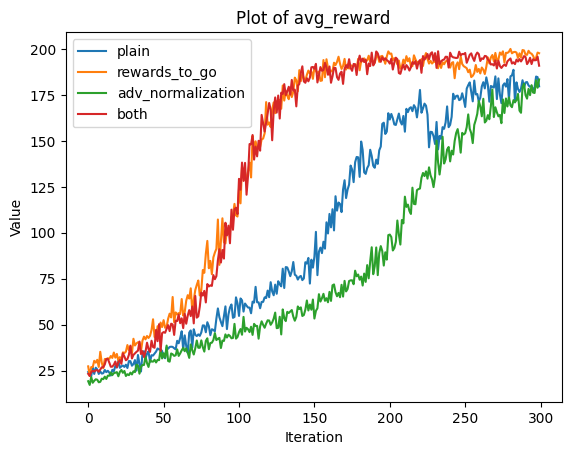

In [15]:
plt.plot(reward_env1_F_F,label = "plain")
plt.plot(reward_env1_T_F,label = "rewards_to_go")
plt.plot(reward_env1_F_T,label = "adv_normalization")
plt.plot(reward_env1_T_T,label = "both")
plt.title('Plot of avg_reward')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

<p>as we can see when we have  rewards to go and advanced normalization turned on we cam see it converged faster.</p>
<p> Convergence: both > rewards to go > adv_normalization > none</p>
<p>from the variance prespective we can see that the one with adv_norm has less variance compared to others.so the order of variance goes as follows</p>
<p>Variance: plain > rewards to go > adv_normalization > both true</p>

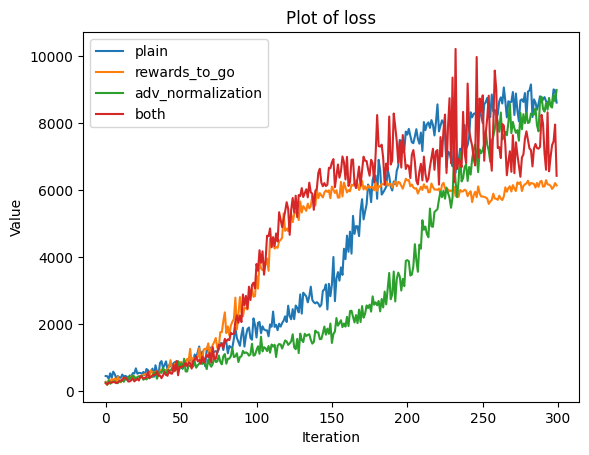

In [14]:
plt.plot(loss_env1_F_F,label = "plain")
plt.plot(loss_env1_T_F,label = "rewards_to_go")
plt.plot(loss_env1_F_T,label = "adv_normalization")
plt.plot(loss_env1_T_T,label = "both")
plt.title('Plot of loss')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

<p>here loss is not directly loss but rather J function</p>

<p>Similar to rewards the convergence and variance trendes also reflected for loss but at the end we can see little deviation this is due to the fact that we are over fitting and alpha is high so in both true case it starts ossilating remaing may haven't reached close to optimal so they are reltively stable </p>

### Batch_size analysis

In [16]:
batch_size = 32
agent1 = Agent(env1,0.99,input_size, output_size,batch_size)
loss_env1_T_T_32 = []
reward_env1_T_T_32 = []

train_agent(agent1,loss_env1_T_T_32,reward_env1_T_T_32, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=True)

loss : 193.66802978515625 , reward: [21.1875]
loss : 296.06768798828125 , reward: [26.5]
loss : 378.2189025878906 , reward: [31.25]
loss : 616.73583984375 , reward: [40.53125]
loss : 1023.5630493164062 , reward: [55.96875]
loss : 1513.365966796875 , reward: [69.96875]
loss : 3310.170166015625 , reward: [115.71875]
loss : 5009.41845703125 , reward: [156.9375]
loss : 7135.24951171875 , reward: [190.875]
loss : 6618.5625 , reward: [187.625]
loss : 5996.2890625 , reward: [182.5625]
loss : 8035.677734375 , reward: [195.78125]
loss : 7375.60888671875 , reward: [195.90625]
loss : 6110.19384765625 , reward: [185.]
loss : 6270.01513671875 , reward: [188.25]


In [17]:
batch_size = 128
agent2 = Agent(env1,0.99,input_size, output_size,batch_size)
loss_env1_T_T_128 = []
reward_env1_T_T_128 = []

train_agent(agent2,loss_env1_T_T_128,reward_env1_T_T_128, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=True)

loss : 215.41168212890625 , reward: [22.5625]
loss : 345.349609375 , reward: [29.4375]
loss : 614.57568359375 , reward: [41.5859375]
loss : 629.585693359375 , reward: [43.1015625]
loss : 882.6825561523438 , reward: [52.625]
loss : 1023.2066650390625 , reward: [58.5390625]
loss : 1496.9345703125 , reward: [73.0703125]
loss : 2981.34716796875 , reward: [113.875]
loss : 4695.86572265625 , reward: [155.890625]
loss : 6318.90380859375 , reward: [187.2421875]
loss : 6994.76318359375 , reward: [193.9375]
loss : 6635.6162109375 , reward: [194.015625]
loss : 9848.791015625 , reward: [198.7890625]
loss : 9055.26953125 , reward: [198.7734375]
loss : 7563.32373046875 , reward: [196.1015625]


### 2c) cartpole

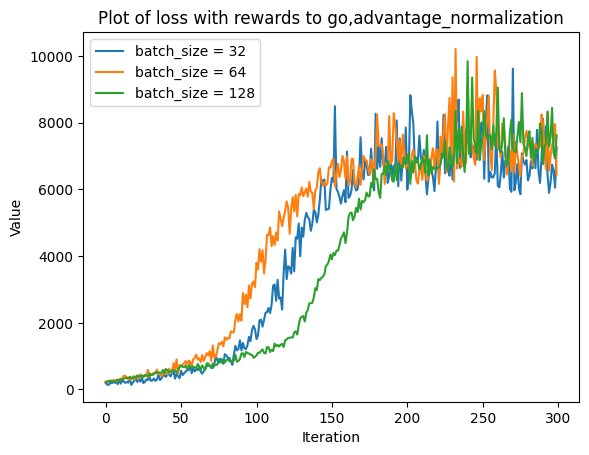

In [31]:
plt.plot(loss_env1_T_T_32,label = "batch_size = 32")
plt.plot(loss_env1_T_T,label = "batch_size = 64")
plt.plot(loss_env1_T_T_128,label = "batch_size = 128")
plt.title('Plot of loss with rewards to go,advantage_normalization')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

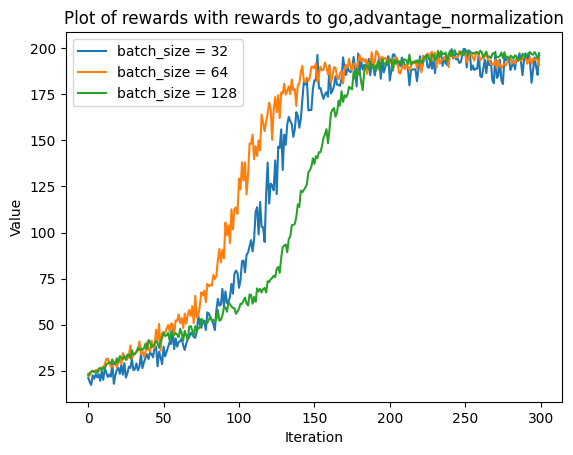

In [32]:
plt.plot(reward_env1_T_T_32,label = "batch_size = 32")
plt.plot(reward_env1_T_T,label = "batch_size = 64")
plt.plot(reward_env1_T_T_128,label = "batch_size = 128")
plt.title('Plot of rewards with rewards to go,advantage_normalization')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

<p>we can see as batch_size 64 is optimal but 128 is large this  is due to the fact that large-batch methods tend to converge to sharp minimizers of the training function also 32 is small resulting in learning less its about finding the right balance but again as iteration increses we can see the one with more batch size tend to have better reward as we get more experience</p>

total_reward:  200.0 count : 200
200


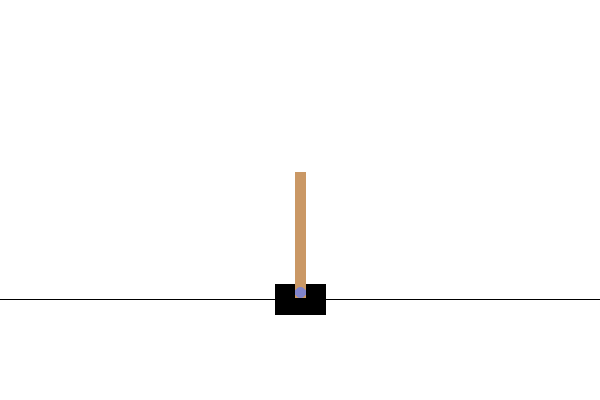

In [19]:
run_testing_and_create_gif(agent,gif_path='testing2.gif')
display(Image(filename='testing2.gif'))

# Lunar Lander

In [ ]:
# !pip install box2d-py

In [6]:
env2 = gym.make('LunarLander-v2')
input_size = env2.observation_space.shape[0]
output_size = env2.action_space.n
batch_size = 32
agent = Agent(env2,0.99,input_size, output_size,batch_size)

In [7]:
loss_env2_T_F = []
reward_env2_T_F = []

train_agent(agent,loss_env2_T_F,reward_env2_T_F, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=False)

loss : -14590.4619140625 , reward: [-203.04642323]
loss : -7596.71337890625 , reward: [-114.15929413]
loss : -8729.845703125 , reward: [-94.54886854]
loss : -3539.671875 , reward: [-12.76335293]
loss : 1680.726318359375 , reward: [51.87215233]
loss : 5252.2890625 , reward: [105.10056937]
loss : 7010.4765625 , reward: [132.2368989]
loss : 7214.85107421875 , reward: [128.59742308]
loss : 4715.0078125 , reward: [110.08689272]
loss : 8335.958984375 , reward: [166.38284469]
loss : 8536.0341796875 , reward: [165.94494033]
loss : 7484.466796875 , reward: [135.72599173]
loss : 7538.20654296875 , reward: [181.98625529]
loss : 6778.70166015625 , reward: [132.90776384]
loss : 6494.9248046875 , reward: [148.08443487]


In [8]:
del agent
agent = Agent(env2,0.99,input_size, output_size,batch_size)
loss_env2_T_T = []
reward_env2_T_T = []

train_agent(agent,loss_env2_T_T,reward_env2_T_T, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=True)

loss : -15107.8037109375 , reward: [-213.95928717]
loss : -6655.455078125 , reward: [-111.79212952]
loss : -7360.357421875 , reward: [-103.6056217]
loss : -5321.4375 , reward: [-65.75007114]
loss : -3471.0869140625 , reward: [-15.71752712]
loss : 4260.55419921875 , reward: [66.72666049]
loss : 8262.654296875 , reward: [110.86124349]
loss : 9233.94921875 , reward: [120.72570515]
loss : 7963.46044921875 , reward: [121.52270925]
loss : 5908.62744140625 , reward: [112.04492247]
loss : 7194.173828125 , reward: [139.0292989]
loss : 7338.53466796875 , reward: [150.28013027]
loss : 6898.33642578125 , reward: [127.59002388]
loss : 8063.88134765625 , reward: [146.87419415]
loss : 6765.23828125 , reward: [139.19327092]


total_reward:  254.9299209320906 count : 345
345


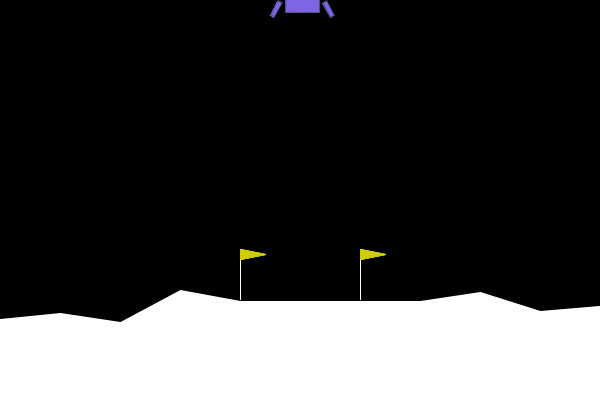

In [ ]:
env3 = gym.make('LunarLander-v2',render_mode = 'rgb_array')
state, _ = env3.reset()
terminated = False
truncated = False
frames = []
total_reward = 0
count = 0
while not (terminated or truncated):
    action_probs = agent.policy_network(torch.tensor(state, dtype=torch.float))
    action = torch.multinomial(action_probs, 1).item()
    next_state,reward,terminated,truncated,_ = env3.step(action)
    state = next_state
    total_reward += reward
    frames.append(env3.render())
    count += 1
env3.close()

print("total_reward: ",total_reward,"count :",count)
print(len(frames))
imageio.mimsave('testing3.gif',frames,duration=0.05)
display(Image(filename='testing3.gif'))

<p>we can see our lander landed perfectly between the poles we observed during testing that we need atleat 120+ reward to able to land inbetween the flags</p>

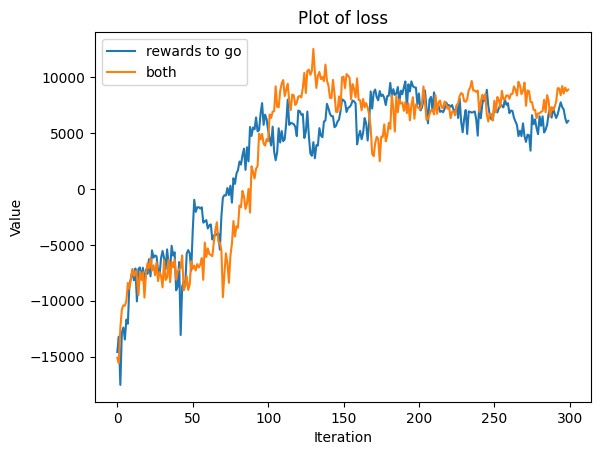

In [10]:
plt.plot(loss_env2_T_F,label = "rewards to go")
plt.plot(loss_env2_T_T,label = "both")
plt.title('Plot of loss')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

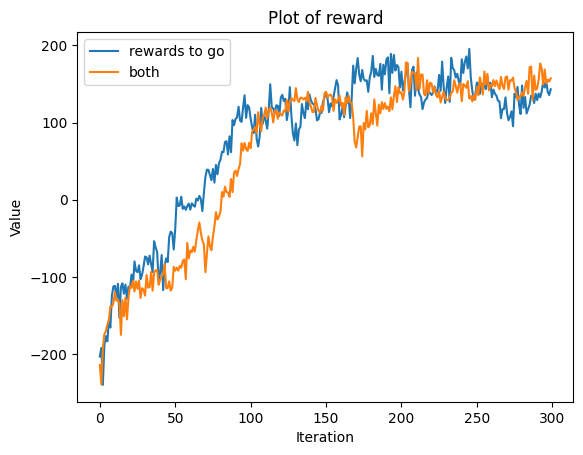

In [16]:
plt.plot(reward_env2_T_F,label = "rewards to go")
plt.plot(reward_env2_T_T,label = "both")
plt.title('Plot of reward')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

<p>intially it looks like rewards to go lerned faster but as the learning progress we can see both true is more stable and has more reward but rewards to go has some fluctuations</p>

In [12]:
env2 = gym.make('LunarLander-v2')
input_size = env2.observation_space.shape[0]
output_size = env2.action_space.n

batch_size = 10
agent = Agent(env2,0.99,input_size, output_size,batch_size)

loss_env2_T_T_10 = []
reward_env2_T_T_10 = []
train_agent(agent,loss_env2_T_T_10,reward_env2_T_T_10, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=True)

loss : -20942.853515625 , reward: [-294.93311691]
loss : -9841.359375 , reward: [-135.28518562]
loss : -9311.640625 , reward: [-132.82953262]
loss : -8021.50146484375 , reward: [-109.127034]
loss : -8020.72021484375 , reward: [-87.0365571]
loss : -2596.64208984375 , reward: [-8.93142052]
loss : 5110.4150390625 , reward: [70.08424931]
loss : 4547.60302734375 , reward: [74.66164474]
loss : -3388.06298828125 , reward: [-18.79239349]
loss : 1653.3218994140625 , reward: [19.15321579]
loss : 8759.0947265625 , reward: [159.93435059]
loss : 3873.698486328125 , reward: [88.52154579]
loss : 4428.67724609375 , reward: [92.03707047]
loss : 5703.2666015625 , reward: [143.54597054]
loss : 2484.665283203125 , reward: [70.80942612]


In [13]:
env2 = gym.make('LunarLander-v2')
input_size = env2.observation_space.shape[0]
output_size = env2.action_space.n

batch_size =  40
agent = Agent(env2,0.99,input_size, output_size,batch_size)

loss_env2_T_T_40 = []
reward_env2_T_T_40 = []
train_agent(agent,loss_env2_T_T_40,reward_env2_T_T_40, num_iterations=300,enable_reward_to_go=True,enable_advantage_normalization=True)

loss : -14210.3232421875 , reward: [-210.64892035]
loss : -6661.5849609375 , reward: [-125.54079418]
loss : -5505.38623046875 , reward: [-106.47260056]
loss : -6465.66357421875 , reward: [-107.24972868]
loss : -6347.18505859375 , reward: [-93.71361165]
loss : -1734.0611572265625 , reward: [1.43725002]
loss : 6462.3486328125 , reward: [84.53014073]
loss : 7654.2744140625 , reward: [108.82116642]
loss : 7590.6220703125 , reward: [174.43056383]
loss : 12160.3095703125 , reward: [225.1170763]
loss : 10073.7197265625 , reward: [199.61058469]
loss : 15047.326171875 , reward: [253.68626442]
loss : 5743.48291015625 , reward: [129.58461585]
loss : 9028.8779296875 , reward: [203.1392334]
loss : 8296.9755859375 , reward: [209.00806856]


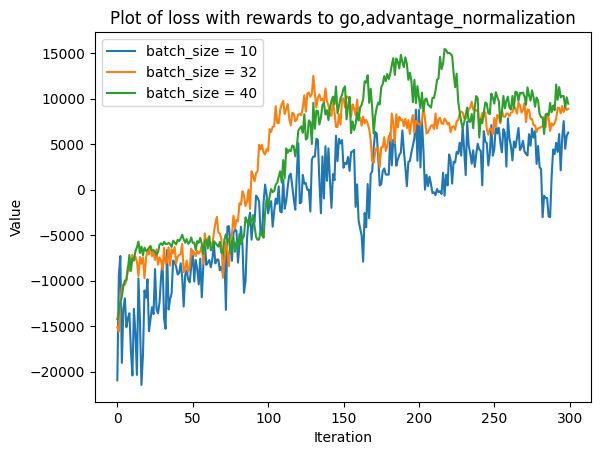

In [14]:
plt.plot(loss_env2_T_T_10,label = "batch_size = 10")
plt.plot(loss_env2_T_T,label = "batch_size = 32")
plt.plot(loss_env2_T_T_40,label = "batch_size = 40")
plt.title('Plot of loss with rewards to go,advantage_normalization')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

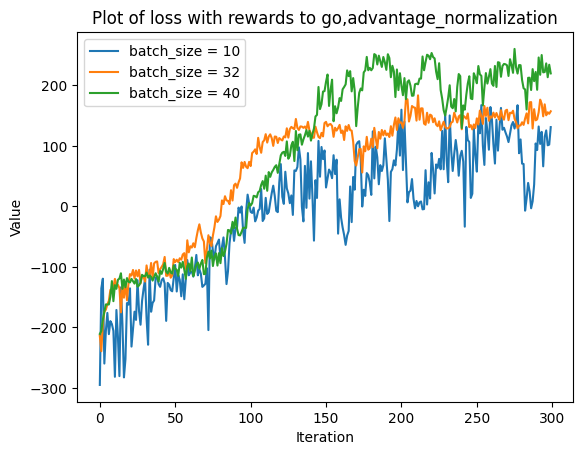

In [15]:
plt.plot(reward_env2_T_T_10,label = "batch_size = 10")
plt.plot(reward_env2_T_T,label = "batch_size = 32")
plt.plot(reward_env2_T_T_40,label = "batch_size = 40")
plt.title('Plot of loss with rewards to go,advantage_normalization')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

<p>the similar argument as above can be applied initlaly we can see the one with batch_size = 32 is optimal and 40 is large and 10 is small but as iteartions increase we can also see  batch_size =40 has better reward followd by batch_size = 32  and 10 this can be attributed to the fact that as more experienced is gained big batch sizes are better</p>